In [29]:
import osmnx as ox
import networkx as nx
import time 
from ipyleaflet import Map
import numpy as np
from math import *
import math
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd
from pandas import json_normalize
import folium 
from folium.plugins import HeatMap
import warnings 
warnings.filterwarnings("ignore")

In [30]:
location_point = (37.4318, -122.1689)
G = ox.graph_from_point(location_point,
                        dist=3000,
                        clean_periphery=True,
                        simplify=True,
                        network_type = "drive"
                       )

In [31]:
origin, destination = 30677855, 10025601806

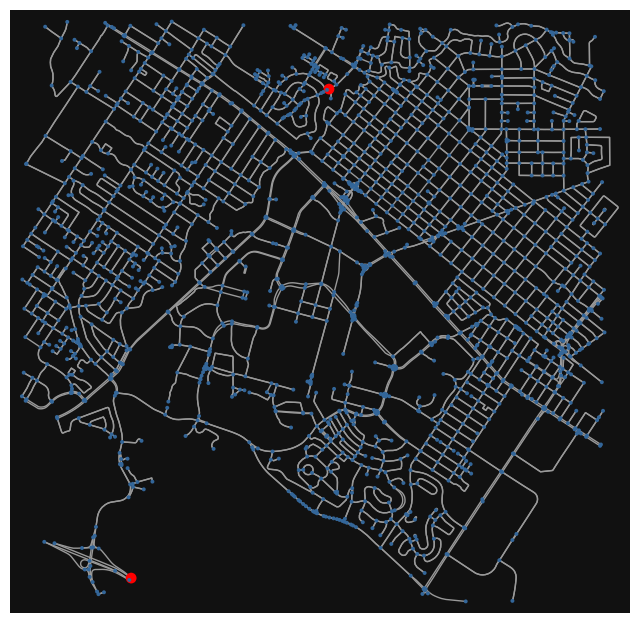

In [32]:
highlighted = [origin,destination]
# marking both the source and destination node
nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [60 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
# add edge speeds :
ox.speed.add_edge_speeds(G, hwy_speeds=None, fallback=None, precision=1)
# add edge travel times :
ox.speed.add_edge_travel_times(G, precision=1)
# add edge bearings :
ox.bearing.add_edge_bearings(G, precision=1)
# add elevation from raster file
# the raster file of the area of interest is obtained from https://srtm.csi.cgiar.org/srtmdata/
ox.elevation.add_node_elevations_raster(G, "srtm_12_05.tif", band=1, cpus=None) 
# add edge grades :
ox.elevation.add_edge_grades(G, add_absolute=True, precision=3)

In [33]:
website = r'https://api.opentopodata.org/v1/'
dataset = 'etopo1?'
# dictionary to save node numbr and height 
elevation = {}    
# place to save location data to pass it to the wesite 
locations = ""
# place to save node index for sake of elevation dictionary
nodes_index = []
i = 0 
# get last element in itertor 
for last in G.nodes:
    pass
# loop to get elevation 
for n in G.nodes:
    locations = locations + str(G.nodes[n]['y']) + ',' + str(G.nodes[n]['x']) + '|'
    nodes_index.append(n)
    i += 1
    if i % 100 == 0  or n == last :
        url = website + dataset + 'locations=' + locations[:-1]
        r = requests.get(url)
        time.sleep(1)#delay between requests
        for segment,k in zip(r.json()['results'], range(len(r.json()['results']))):
            elevation[nodes_index[k]] = segment['elevation']
        locations = ""
        i = 0 
        nodes_index = []

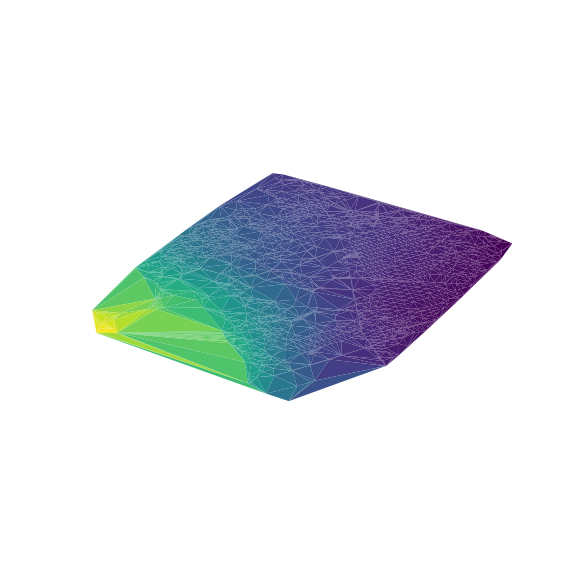

In [34]:
x = []
y = []
z = []
for node in G.nodes:
    x.append(G.nodes[node]['x'])
    y.append(G.nodes[node]['y'])
    z.append(elevation[node])

#ax = plt.axes(projection='3d')    
#ax.scatter(x, y, z)
#plt.show()
x = np.array(x)
y = np.array(y)
x = (x - np.min(x)) * 111000     #111000
y = (y - np.min(y)) * 180000
ax = plt.figure(figsize=(6, 6), dpi=120).add_subplot(projection='3d')
ax.plot_trisurf(x, y, z, linewidth=0.3, antialiased=True, cmap=plt.cm.viridis)
ax.set_box_aspect((np.max(x), np.max(y), np.max(z)*2.5))
plt.axis('off')
#ax.view_init(elev=50, azim=20)
plt.show()

In [35]:
def Estimate_Co2_Model2(gl=0, v=15, length= 0):
    '''
    format of received paremeters :
        gl -----------> (in percentage)
        length -------> m
        v ------------> m/s
        
    '''
    
    length /= 1609.344
    v *= 2.23693629
    '''
    model parameters : 
        length -------> miles
        v ------------> (in miles per hour)
        fuel ---------> grams per mile
    ''' 
    
    # car parameters:
    alpha=[6.8, -0.14, 0.00392, -0.000052, 0.000000257, 0.137]
    # fuel consumption gram per mile :
    ft = exp(alpha[0] + alpha[1] * v + alpha[2] * v**2 + alpha[3] * v**3 + alpha[4] * v**4 + alpha[5] * gl)
    # fuel consumption gram :
    fuel = ft * length
    return fuel

In [36]:
def get_distance_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['length']
        weight += leng
    return weight
def get_time_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        leng = G[u][v][0]['travel_time']
        weight += leng
    return weight
def get_fuel_cost(G, route):
    route = list(route)
    weight = 0
    for u,v in zip(route[:-1], route[1:]):
        point1_h = elevation[u]
        point2_h = elevation[v]
        leng = G[u][v][0]['length']
        grad = np.max([(point2_h -point1_h) / leng * 100, 0])
        speed = G[u][v][0]['speed_kph'] * 0.277777778 * 3
        fuel = Estimate_Co2_Model2(grad, speed, leng)
        weight += fuel
    return weight
        

In [37]:
def func(G, node1, node2, criteria):

    if criteria =='Distance':
        distance = G[node1][node2][0]['length'] # length between the nodes
    elif criteria == 'Time':
        distance = G[node1][node2][0]['travel_time'] # time between the nodes
    elif criteria == 'Fuel':
        point1_h = elevation[node1]
        point2_h = elevation[node2]
        leng = G[node1][node2][0]['length'] 
        grad = np.max([(point2_h -point1_h) / leng * 100, 0])
        speed = G[node1][node2][0]['speed_kph']  * 0.277777778 * 3
        distance = Estimate_Co2_Model2(grad, speed, leng)
    return distance

In [38]:
def Dijkstra(G,origin,destination, criteria = 'Distance'):

    map_nodes = list(G.nodes)
    
    origin = map_nodes.index(origin)
    destination = map_nodes.index(destination)
    
    open_list = []


    # set to hold already processed nodes
    closed_list = set()


    # dict for mapping children to parent
    parents = dict()


    # dict for mapping g costs (travel costs) to nodes
    g_costs = dict()


    # set the start's node g_cost
    g_costs[origin] = 0


    # add start node to open list
    open_list.append([origin, 0])


    shortest_path = []
    path_found = False
    while open_list:
        open_list.sort(key = lambda x:x[1])
        current_node = open_list.pop(0)[0]
        closed_list.add(current_node)
        if current_node == destination:
            path_found = True
            break
        for child in nx.neighbors(G,map_nodes[current_node]):
            child = map_nodes.index(child)
            if child in closed_list:
                continue
            g_cost = g_costs[current_node] + func(G,map_nodes[current_node],map_nodes[child], criteria)
            in_open_list = False
            for idx, element in enumerate(open_list):
                if element[0] == child:
                  in_open_list = True
                  break
            #Case 1, already in open list
            if in_open_list:
                if g_cost < g_costs[child]:
                    #update nodes csot in g_costs
                    g_costs[child] = g_cost
                    parents[child] = current_node
                    #upadte nodes cost in open_list
                    open_list[idx] = [child, g_cost]
            #Case 2, not in open list
            else:
                #set the node's g_cost inside g_costs
                g_costs[child] = g_cost
                parents[child] = current_node
                #add the node to the open list
                open_list.append([child, g_cost])
    if not path_found:
        print('Dijkstra: No path found!')
        return shortest_path

    # Reconstruct path by working backwards from target
    if path_found:
        node = destination
        shortest_path.append(destination)
        while node != origin:
            shortest_path.append(node)
          # get next node
            node = parents[node]
    # reverse list

    shortest_path = shortest_path[::-1]
    print('Dijkstra: Done reconstructing path')
    shortest_path = [map_nodes[i] for i in shortest_path]
    shortest_path.insert(0, map_nodes[origin])
    shortest_path = shortest_path[:-1]
    return shortest_path

Dijkstra: Done reconstructing path
Dijkstra: Done reconstructing path
Dijkstra: Done reconstructing path


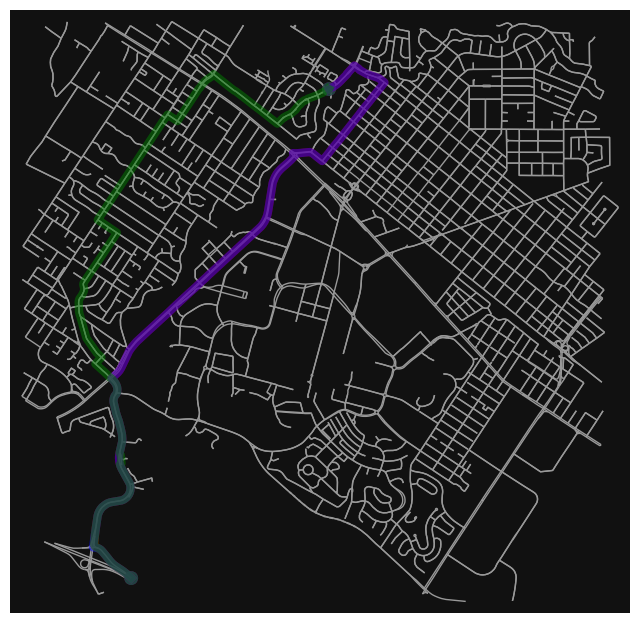

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [39]:
route1 = Dijkstra(G,origin,destination, 'Distance')
route2 = Dijkstra(G,origin,destination, 'Time')
route3 = Dijkstra(G,origin,destination, 'Fuel')
ox.plot_graph_routes(G, 
                     [route1, route2, route3], 
                     route_colors=['r', 'b', 'g'], 
                     route_linewidths=6, 
                     node_size=0)

In [40]:
print("For route with minimum distance : ")
print("Distance cost : ", get_distance_cost(G, route1), ' m')
print("Time cost :", get_time_cost(G, route1), 'sec')
print("Fuel cost :", get_fuel_cost(G, route1), 'gram')
# ------------------------------------- #
print("")
print("For route with minimum time : ")
print("Distance cost : ", get_distance_cost(G, route2), ' m')
print("Time cost :", get_time_cost(G, route2), 'sec')
print("Fuel cost :", get_fuel_cost(G, route2), 'gram')
# -------------------------------------- #
print("")
print("For route with minimum fuel : ")
print("Distance cost : ", get_distance_cost(G, route3), ' m')
print("Time cost :", get_time_cost(G, route3), 'sec')
print("Fuel cost :", get_fuel_cost(G, route3), 'gram')

For route with minimum distance : 
Distance cost :  7647.026000000001  m
Time cost : 535.0000000000002 sec
Fuel cost : 1183709.947358857 gram

For route with minimum time : 
Distance cost :  7670.227000000001  m
Time cost : 534.1000000000001 sec
Fuel cost : 2573837.723300978 gram

For route with minimum fuel : 
Distance cost :  8040.520000000004  m
Time cost : 647.5000000000001 sec
Fuel cost : 1181526.570255718 gram


In [41]:
from sklearn import preprocessing
import pickle
scalerfile = 'scaler.sav'
#preload a scaler that will scale distance, time, fuel data to be between 0-1
scaler = pickle.load(open(scalerfile, 'rb'))
#test it on random data
test_scaled_set = scaler.transform([[2,3,4]])
print(test_scaled_set)

[[ 0.00186512 -0.00659155  0.06822612]]


In [42]:
def a_star(G,origin,destination, criteria = 'Distance'):

    map_nodes = list(G.nodes)
    
    origin = map_nodes.index(origin)
    destination = map_nodes.index(destination)
    
    open_list = []


    # set to hold already processed nodes
    closed_list = set()


    # dict for mapping children to parent
    parents = dict()


    # dict for mapping g costs (travel costs) to nodes
    h_costs = dict()


    # set the start's node g_cost
    h_costs[origin] = 0


    # add start node to open list
    open_list.append([origin, 0])


    shortest_path = []
    path_found = False
    while open_list:
        open_list.sort(key = lambda x:x[1])
        current_node = open_list.pop(0)[0]
        closed_list.add(current_node)
        if current_node == destination:
            path_found = True
            break
        for child in nx.neighbors(G,map_nodes[current_node]):
            child = map_nodes.index(child)
            if child in closed_list:
                continue

            fuel_h = func(G,map_nodes[current_node],map_nodes[child], 'Fuel')
            distance_h = func(G,map_nodes[current_node],map_nodes[child], 'Distance')
            time_h = func(G,map_nodes[current_node],map_nodes[child], 'Time')
            #add newly calulated heuristic to the heuristic of the current node
            h_cost = h_costs[current_node] + np.sum(scaler.transform([[fuel_h, distance_h, time_h]]))
            
            in_open_list = False
            for idx, element in enumerate(open_list):
                if element[0] == child:
                  in_open_list = True
                  break
            #Case 1, already in open list
            if in_open_list:
                if h_cost < h_costs[child]:
                    #update nodes csot in h_costs
                    h_costs[child] = h_cost
                    parents[child] = current_node
                    #upadte nodes cost in open_list
                    open_list[idx] = [child, h_cost]
            #Case 2, not in open list
            else:
                #set the node's h_cost inside h_costs
                h_costs[child] = h_cost
                parents[child] = current_node
                open_list.append([child, h_cost])
    if not path_found:
        print('Dijkstra: No path found!')
        return shortest_path

    # Reconstruct path by working backwards from target
    if path_found:
        node = destination
        shortest_path.append(destination)
        while node != origin:
            shortest_path.append(node)
          # get next node
            node = parents[node]
    # reverse list

    shortest_path = shortest_path[::-1]
    print('Dijkstra: Done reconstructing path')
    shortest_path = [map_nodes[i] for i in shortest_path]
    shortest_path.insert(0, map_nodes[origin])
    shortest_path = shortest_path[:-1]
    return shortest_path

Dijkstra: Done reconstructing path


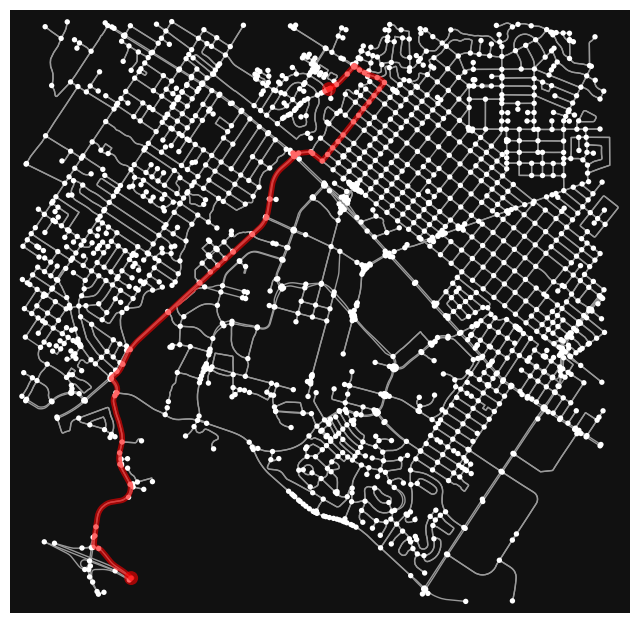

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [43]:
route4 = a_star(G,origin,destination, 'Fuel')
ox.plot_graph_route(G, route1, route_color='r', route_linewidth=4, route_alpha=0.6)

In [44]:
x = []
y = []
z = []
for node in G.nodes:
    x.append(G.nodes[node]['x'])
    y.append(G.nodes[node]['y'])
    z.append(G.nodes[node]['elevation'])
x = np.array(x)
y = np.array(y)
z = np.array(z)
data=np.array([y,x,z]).T

In [45]:
# generate a new map
folium_map = folium.Map(location=location_point,
                        zoom_start=13,
                        tiles="OpenStreetMap")
paths = [route1, route2, route3, route4]
color_list = ['#FF3333', '#0F3FE5', '#55DF15']    # red, blue, green
for path,color in zip(paths,color_list):
    path_coordinates = []
    for i in path:
        path_coordinates.append([G.nodes[i]['y'],G.nodes[i]['x']])
    line = folium.PolyLine(path_coordinates,
                           weight=4,
                           color=color
                          ).add_to(folium_map)
# add folium marker
folium.Marker(location=[G.nodes[highlighted[0]]['y'],
                        G.nodes[highlighted[0]]['x']],
              icon= folium.Icon(color='blue',icon='map-marker'),
              popup = 'Origin').add_to(folium_map)

folium.Marker(location=[G.nodes[highlighted[1]]['y'],
                        G.nodes[highlighted[1]]['x']],
              icon= folium.Icon(color='red',icon='map-marker'),
              popup = 'Destination').add_to(folium_map)


HeatMap(data, radius=15, opacity = 1).add_to(folium.FeatureGroup(name='Heat Map').add_to(folium_map))
folium.LayerControl().add_to(folium_map)
# show the map layers:
folium_map